<a href="https://colab.research.google.com/github/adityadeshmukh369/Music-Generation/blob/main/MusicGene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Importing all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117305 sha256=bf5801b87a9ff788070ad27d9627c9a37248dd2b36c3d148531d1231a7256d5f
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


In [2]:
# Downloading the dataset
songs = mdl.lab1.load_training_data()


Found 817 songs in text


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:

# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [4]:
type(vocab)

list

In [5]:
char2idx = {x:i for i,x in enumerate(vocab)}
idx2char = np.array(vocab)

In [6]:
# Converts word to numbers
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [7]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1
  # retrun array of batch_size where idx[i] is between (0,n-seq_length)
  # Below line is same as np.random.randint(0,n-seq_length,batch_size) where n-seq_length is not included
  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1:i+1+seq_length] for i in idx]
  x_batch = np.reshape(input_batch,[batch_size,seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

In [8]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
      rnn_units,
      return_sequences=True,
      recurrent_initializer='glorot_uniform',
      recurrent_activation='sigmoid',
      stateful=True,
  )


In [9]:

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    LSTM(rnn_units),
    tf.keras.layers.Dense(vocab_size)

  ])
  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [11]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)

In [12]:
# Why does we have use sparse_categorical_crossentropy ?
# Since the musical notation are limited i.e around 70 and they have descrete class so we used the above fucntion
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss
example_batch_loss = compute_loss(y, pred)

In [13]:
num_training_iterations = 2000
batch_size = 4
seq_length = 100
learning_rate = 5e-3

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [14]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

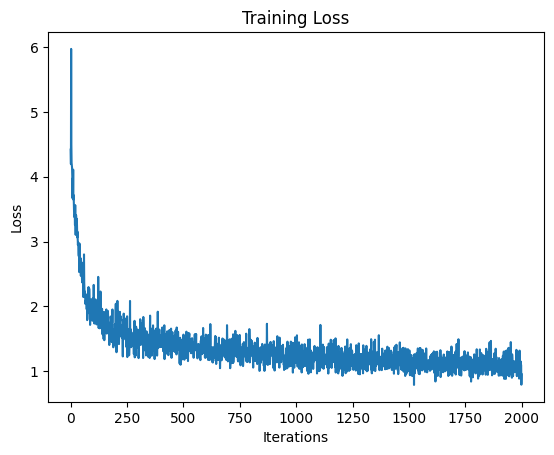

In [15]:
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
import matplotlib.pyplot as plt


history = []
for iter in range(num_training_iterations):
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)
  history.append(loss.numpy().mean())

plt.plot(range(num_training_iterations), history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [16]:
model1 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model1.set_weights(model.get_weights())
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [17]:
def generate_text(model, start_string, generation_length=1000):
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model1(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))


In [18]:
generated_text = generate_text(model, start_string="a", generation_length=1000)

100%|██████████| 1000/1000 [00:09<00:00, 100.48it/s]


In [23]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  waveform = mdl.lab1.play_song(song)
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)


Found 4 songs in text
Generated song 1


Generated song 2


Generated song 3
